In [1]:
import numpy as np
import pandas as pd
import os
import math
import seaborn as sea
import matplotlib.pyplot as plot
import torch
from torch.utils.data import TensorDataset
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from tqdm.auto import tqdm
from datetime import datetime

In [2]:
# Mount data from drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# local path
#import_dir = 'output_csv/'
# francesco drive path
import_dir = '/content/drive/MyDrive/Colab Notebooks/DL/progetto/output_csv/'
# christian drive path
#import_dir = '/content/drive/MyDrive/deep_learning/progetto/output_csv/'

export_dir = import_dir

In [107]:
#kaggle
#import_dir = '/kaggle/input/'
#export_dir = '/kaggle/working/output_csv/'
#print(os.path.exists(export_dir))
#if(not os.path.exists(export_dir)) :
#    os.makedirs(export_dir)
#print(os.path.exists(export_dir))

In [129]:
#kaggle
#for dirname, _, filenames in os.walk(import_dir):
#    for filename in filenames :
#        if(filename == dataset_filename) :
#            data = pd.read_csv(os.path.join(dirname, filename))

In [150]:
possible_dates = {
    1: '2021-12-15_21:25:16', #christian without inception
    2: '2021-12-15_20:50:39', #francesco with    inception
}

cur_idx = 1
import_date_time = possible_dates[cur_idx]
print(cur_idx)

1


In [151]:
#import parameters, analysis to csv file
extension = '.csv'
sep=';'
index_col = 'Unnamed: 0'

y_pred_real_df = None
params_df = None
analysis_df = None
losses_accuracies_df = None

y_pred_real_filename = (import_dir + import_date_time + "_y_pred_real_" + extension)
exists = os.path.exists(y_pred_real_filename)
if(exists) :
  y_pred_real_df = pd.read_csv(y_pred_real_filename, sep=sep).drop(columns=[index_col])
print(exists, "\t", y_pred_real_filename)

params_filename = (import_dir + import_date_time + "_params_" + extension)
exists = os.path.exists(params_filename)
if(exists) :
  params_df = pd.read_csv(params_filename, sep=sep).drop(columns=[index_col]).T
print(exists, "\t", params_filename)

analysis_filename = (import_dir + import_date_time + "_analysis_" + extension)
exists = os.path.exists(analysis_filename)
if(exists) :
  analysis_df = pd.read_csv(analysis_filename, sep=sep).drop(columns=[index_col])
print(exists, "\t", analysis_filename)

losses_accuracies_filename = (import_dir + import_date_time + "_losses_accuracies_" + extension)
exists = os.path.exists(losses_accuracies_filename)
if(exists) :
  losses_accuracies_df = pd.read_csv(losses_accuracies_filename, sep=sep).drop(columns=[index_col])
print(exists, "\t", losses_accuracies_filename)

True 	 /content/drive/MyDrive/Colab Notebooks/DL/progetto/output_csv/2021-12-15_21:25:16_y_pred_real_.csv
True 	 /content/drive/MyDrive/Colab Notebooks/DL/progetto/output_csv/2021-12-15_21:25:16_params_.csv
True 	 /content/drive/MyDrive/Colab Notebooks/DL/progetto/output_csv/2021-12-15_21:25:16_analysis_.csv
True 	 /content/drive/MyDrive/Colab Notebooks/DL/progetto/output_csv/2021-12-15_21:25:16_losses_accuracies_.csv


In [152]:
print(params_df)

                                               0
n_epochs                                      35
learning_rate                              5e-05
weight_decay                               1e-09
dropout_prob                                0.35
conv__in_channels                              3
conv__out_channels        (288, 566, 1122, 2244)
conv__layer_repetitions             (4, 3, 2, 1)
lin__out_dimension       (1024, 356, 158, 64, 7)
loss_fn                       CrossEntropyLoss()
optimizer                                   Adam
split_seed                                    78
scheduler                                  False


In [153]:
print(analysis_df)

    emotions  true_preds  false_preds  accuracy
0       rage         358          385  0.481830
1    disgust          41           41  0.500000
2       fear         339          429  0.441406
3  happiness        1104          244  0.818991
4    sadness         460          451  0.504940
5   surprise         439          162  0.730449
6    neutral         538          392  0.578495


In [154]:
err_col = 'val_accuracies'
last_val_acc = losses_accuracies_df.tail(1)[err_col].values[0]
if (last_val_acc < 0.2) :
  #fix bug in code 
  losses_accuracies_df[err_col] = losses_accuracies_df[err_col] * 169 / 32
  #export correct data
  losses_accuracies_df.to_csv(losses_accuracies_filename, sep=sep)
  print('error fixed, correct data overwritten')
else :
  print('no error')

no error


In [155]:
print(losses_accuracies_df)

    train_losses  val_losses  train_accuracies  val_accuracies
0      30.080031   29.808677          0.242038        0.249629
1      29.406308   29.112337          0.248169        0.251484
2      28.602523   27.050937          0.268471        0.311387
3      26.525268   24.644783          0.341879        0.401706
4      25.005489   23.770027          0.387341        0.421921
5      24.158130   23.187081          0.410987        0.433049
6      23.490010   22.927328          0.429658        0.438613
7      22.694200   21.816606          0.450876        0.474036
8      21.837372   20.796871          0.475557        0.509829
9      21.090621   20.594000          0.495740        0.505564
10     20.521208   19.975052          0.509713        0.520957
11     19.801594   19.338408          0.527389        0.537648
12     19.141309   19.463582          0.546696        0.537463
13     18.389402   18.765181          0.568949        0.556380
14     17.878853   18.315630          0.579578        0

In [156]:
true_preds  = analysis_df['true_preds']
false_preds = analysis_df['false_preds']

In [157]:
emotions =  ('rage',   'disgust',  'fear',  'happiness', 'sadness',   'surprise', 'neutral')
num_of_emotions = len(emotions)
count_emotions = [ (np.sum(true_preds[i]) + np.sum(false_preds[i])) for i in range(num_of_emotions) ]
print(emotions)
print(count_emotions)

('rage', 'disgust', 'fear', 'happiness', 'sadness', 'surprise', 'neutral')
[743, 82, 768, 1348, 911, 601, 930]


In [158]:
def print_image(ima, labelI, val=False, subpl="",title=""):
    if subpl=="":
      plot.imshow((ima).detach().numpy().reshape((48,48)), cmap='gray')
      plot.title(emotions[labelI]+ ((" "+ str(labelI)) if val else ""))
    else :
      subpl.imshow((ima).detach().numpy().reshape((48,48)), cmap='gray')
      subpl.set_title(((" "+ str(title)) if title!="" else ""))

In [159]:
#remove batch divisions, get only predn_featuress

accuracy = [ (true_preds[i] / (true_preds[i] + false_preds[i])) for i in range(num_of_emotions) ]
total_approx_acc = np.mean(accuracy)
total_true = np.sum(true_preds)
total_false = np.sum(false_preds)
total_real_acc = total_true / (total_true + total_false)

print(f"{total_approx_acc:.5f} mean of accuracy of each label")
print(f"{total_real_acc:.5f} accuracy of all test set")
print(analysis_df)



0.57944 mean of accuracy of each label
0.60914 accuracy of all test set
    emotions  true_preds  false_preds  accuracy
0       rage         358          385  0.481830
1    disgust          41           41  0.500000
2       fear         339          429  0.441406
3  happiness        1104          244  0.818991
4    sadness         460          451  0.504940
5   surprise         439          162  0.730449
6    neutral         538          392  0.578495


In [160]:
def plot_losses(train_losses, val_losses):
      plot.plot(train_losses, label="Training loss")
      plot.plot(val_losses, label="Validation loss")
      plot.legend()
      plot.title("Evolution of losses over time")
      plot.xlabel("Epochs")
      plot.ylabel("Losses")
      plot.show()
      plot.close()

def plot_accuracies(train_accuracies, val_accuracies):
    plot.plot(train_accuracies, label="Training accuracy")
    plot.plot(val_accuracies, label="Validation accuracy")
    plot.legend()
    plot.title("Evolution of accuracies over time")
    plot.xlabel("Epochs")
    plot.ylabel("Accuracies")
    plot.show()
    plot.close()

def plot_losses_accuracies(train_losses, val_losses, train_accuracies, val_accuracies, figsize=(12,4)):
    fig, axs = plot.subplots(1, 2, figsize=figsize)
    #losses
    plot_1 = axs[0]
    plot_1.plot(train_losses, label="Training loss")
    plot_1.plot(val_losses, label="Validation loss")
    plot_1.legend()
    plot_1.set_title("Evolution of losses over time")
    plot_1.set_xlabel("Epochs")
    plot_1.set_ylabel("Losses")
    #accuracies
    plot_2 = axs[1]
    plot_2.plot(train_accuracies, label="Training accuracy")
    plot_2.plot(val_accuracies, label="Validation accuracy")
    plot_2.legend()
    plot_2.set_title("Evolution of accuracies over time")
    plot_2.set_xlabel("Epochs")
    plot_2.set_ylabel("Accuracies")

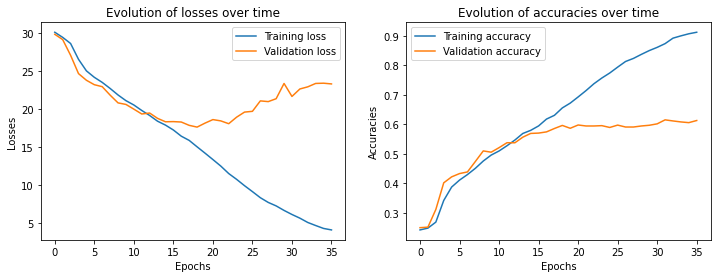

In [161]:
plot_losses_accuracies(losses_accuracies_df['train_losses'], losses_accuracies_df['val_losses'], losses_accuracies_df['train_accuracies'], losses_accuracies_df['val_accuracies'])

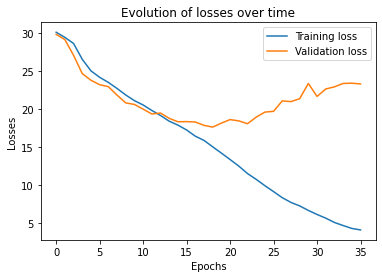

In [162]:
plot_losses(losses_accuracies_df['train_losses'], losses_accuracies_df['val_losses'])

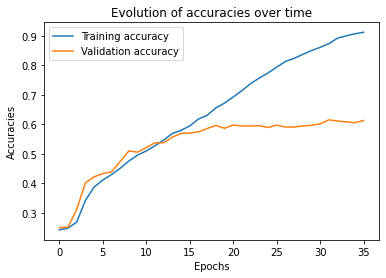

In [163]:
plot_accuracies(losses_accuracies_df['train_accuracies'], losses_accuracies_df['val_accuracies'])

In [164]:
y_pred = y_pred_real_df['y_pred_list']
y_real = y_pred_real_df['y_test_list']
print(y_pred_real_df)

      y_pred_list  y_test_list
0               4            0
1               6            6
2               3            3
3               6            6
4               0            0
...           ...          ...
5378            5            5
5379            3            4
5380            3            3
5381            6            6
5382            4            4

[5383 rows x 2 columns]


In [165]:
conf_matrix = confusion_matrix(y_real, y_pred)
print(conf_matrix)

[[ 358   11   69   53  103   22  127]
 [   8   41    8    4   12    2    7]
 [  83    6  339   33  162   60   85]
 [  44    2   43 1104   48   43   64]
 [  91    8  112   67  460   10  163]
 [  15    1   62   30   15  439   39]
 [  57    2   50  117  154   12  538]]


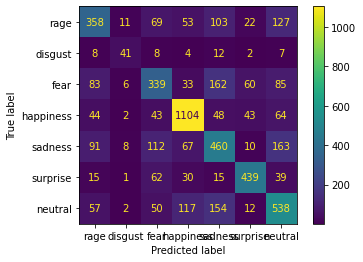

<Figure size 432x288 with 0 Axes>

In [166]:
display = ConfusionMatrixDisplay(conf_matrix, display_labels=emotions)
display.plot()
plot.show()
plot.savefig("confusion_matrix" + import_date_time + ".png")

In [167]:
#!pip install scikit-plot

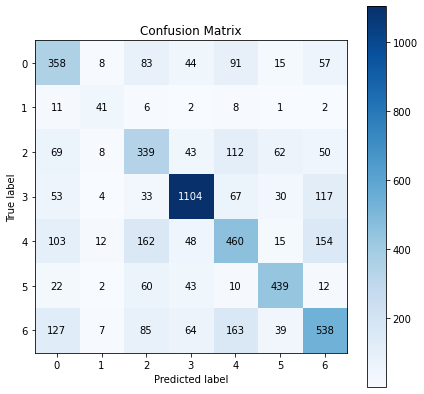

In [168]:
import scikitplot
scikitplot.metrics.plot_confusion_matrix(y_pred, y_real, figsize=(7,7))
plot.savefig("confusion_matrix.png")

In [169]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.preprocessing import label_binarize

# precision recall curve
precision = dict()
recall = dict()
for i in range(num_of_emotions):
    precision[i], recall[i], _ = precision_recall_curve(y_real[:, i], y_pred[:, i])
    plot.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
    
plot.xlabel("recall")
plot.ylabel("precision")
plot.legend(loc="best")
plot.title("precision vs. recall curve")
plot.show()

KeyError: ignored